In [4]:
import yfinance as yf
import pandas as pd
from datetime import datetime
import numpy as np

symbol = 'tsla'
start_date = '2000-01-01'
end_date = '2020-01-01'

start_date_obj = datetime.strptime(start_date, "%Y-%m-%d")
end_date_ojb = datetime.strptime(end_date, "%Y-%m-%d")

def download_data(symbol):
    price_raw = yf.download(symbol, start=start_date, end=end_date)
    price_raw.to_csv(symbol + '.csv')
    ticker = yf.Ticker(symbol)
    ticker.get_earnings_dates(limit=100).to_csv(symbol + '_earnings_dates')
    
#download_data(symbol)

In [5]:
prices = pd.read_csv(symbol + '.csv').iloc[2:,:].rename(columns={'Price': 'Date'})
prices['Date'] = pd.to_datetime(prices['Date'])
prices = prices.set_index('Date')
prices = prices.astype(float)
prices['Percent Change'] = prices['Close'].pct_change()
prices

,Close,High,Low,Open,Volume,Percent Change
Date,,,,,,
2010-06-29,1.592667,1.666667,1.169333,1.266667,281494500.0,NaN
2010-06-30,1.588667,2.028000,1.553333,1.719333,257806500.0,-0.002511
2010-07-01,1.464000,1.728000,1.351333,1.666667,123282000.0,-0.078473
2010-07-02,1.280000,1.540000,1.247333,1.533333,77097000.0,-0.125683
2010-07-06,1.074000,1.333333,1.055333,1.333333,103003500.0,-0.160937
...,...,...,...,...,...,...
2019-12-24,28.350000,28.364668,27.512667,27.890667,120820500.0,0.014384
2019-12-26,28.729334,28.898666,28.423332,28.527332,159508500.0,0.013380
2019-12-27,28.691999,29.020666,28.407333,29.000000,149185500.0,-0.001300


In [6]:
threshold = 0.06

def get_metrics(threshold=threshold, back=60):
    column_names = []
    columns = []
    for d in range(3, back):
        columns.append((prices['Percent Change'] > threshold).rolling(window=d, closed='left').sum())
        column_names.append('Positive Count' + str(d))
        columns.append(prices['Percent Change'].rolling(window=d, closed='left').std() * np.sqrt(252))
        column_names.append('Volatility' + str(d))
        columns.append(prices['Volume'].shift(1) / prices['Volume'].rolling(window=d, closed='left').mean())
        column_names.append('Rvol' + str(d))
        
        hi = prices['High'].rolling(window=d, closed='left').max()
        lo = prices['Low'].rolling(window=d, closed='left').min()
        columns.append((prices['Close'].shift(1) - lo) / (hi - lo))
        column_names.append('Price Position' + str(d))
    
    data = pd.concat(columns, join='outer', axis=1)
    data.columns = column_names

    indexer = pd.api.indexers.FixedForwardWindowIndexer(window_size=5)
    data['next_prices'] = prices['High'].shift(-1).rolling(window=indexer).max()
    data['MONEY'] = (data['next_prices'] > prices['Close'].shift(1) * (1 + threshold)).astype(int)
    data = data.dropna().drop('next_prices', axis=1)
    return data

stock_data = get_metrics(threshold=threshold)
stock_data['MONEY'].value_counts()


MONEY
0    1405
1     924
Name: count, dtype: int64

Model final amount: 2.354684643897832
Dummy final amount: 0.8796571851831712
Model overall accuracy: 0.8461538461538461
Dummy overall accuracy: 0.5769230769230769
Model buy rate: 0.3076923076923077


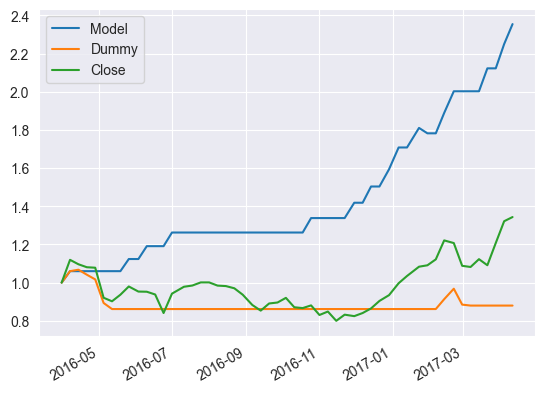

In [30]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyClassifier

def money_update(money, prediction, truth, start, holding_period=5, threshold=threshold):
    if prediction == truth:
        if prediction == 1:
            money *= 1 + (prediction * threshold)
    else:
        if prediction == 1:
            start = prices.index.get_loc(stock_data.index[start])
            money *= prices['Close'].iloc[start+holding_period] / prices['Close'].iloc[start+1]
    return money

def backtest(model, start, folds=52, train_size=60):
    '''
    Simulates model on past stock data to analyze performance compared to dummy
    :param model: sklearn model
    :param start: datetime object, which day to start the backtest
    :param folds: how many weeks to simulate
    :param train_size: how many days prior to train model on
    :return: pandas df of model performance metrics
    '''
    dummy = DummyClassifier(strategy='most_frequent')
    performance = pd.DataFrame({'prev': [1, 1, np.nan, np.nan, np.nan]}, index=['Model', 'Dummy', 'Model Accuracy', 'Model Decision Was', 'Dummy Accuracy'])
    train_id = stock_data.index.get_loc(start)
    test_id = train_id + train_size
    for f in range(folds):
        test_date = stock_data.index[test_id].date()
        X_train, X_test = X[train_id:test_id], X[test_id]
        y_train, y_test = y[train_id:test_id], y[test_id]
        
        #print(f'\nFold {f + 1}')
        #print(f"Train: {stock_data.index[train_id].date()} to {stock_data.index[test_id - 1].date()}")
        #print(f"Test: {test_date}")
        
        model.fit(X_train, y_train)
        dummy.fit(X_train, y_train)
        y_hat = model.predict(X_test.reshape(1, -1))[0]
        y_fat = dummy.predict(X_test.reshape(1, -1))[0]

        prev = performance['prev']
        performance = performance.rename({'prev': test_date}, axis=1)
        model_money = money_update(prev['Model'], y_hat, y_test, test_id)
        dummy_money = money_update(prev['Dummy'], y_fat, y_test, test_id)
        performance['prev'] = [model_money, dummy_money, y_hat == y_test, y_hat, y_fat == y_test]

        train_id += 5
        test_id += 5
    final_test_date = pd.Timestamp(performance.columns[-2])
    performance = performance.rename({'prev': prices.index[prices.index.get_loc(final_test_date) + 5]}, axis=1)
    performance.columns = pd.to_datetime(performance.columns)
    return performance.T
    
X = stock_data.iloc[:,:-1].values
y = stock_data['MONEY'].values

scaler = StandardScaler()
X = scaler.fit_transform(X)

model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
results = backtest(model, datetime(2016, 1, 4), folds=52)
results['Close'] = prices['Close']
results['Close'] = results['Close'] / results['Close'].iloc[0]
results[['Model', 'Dummy', 'Close']].plot()
print('Model final amount:', results['Model'].iloc[-1])
print('Dummy final amount:', results['Dummy'].iloc[-1])
print('Model overall accuracy:', results['Model Accuracy'].mean())
print('Dummy overall accuracy:', results['Dummy Accuracy'].mean())
print('Model buy rate:', results['Model Decision Was'].mean())


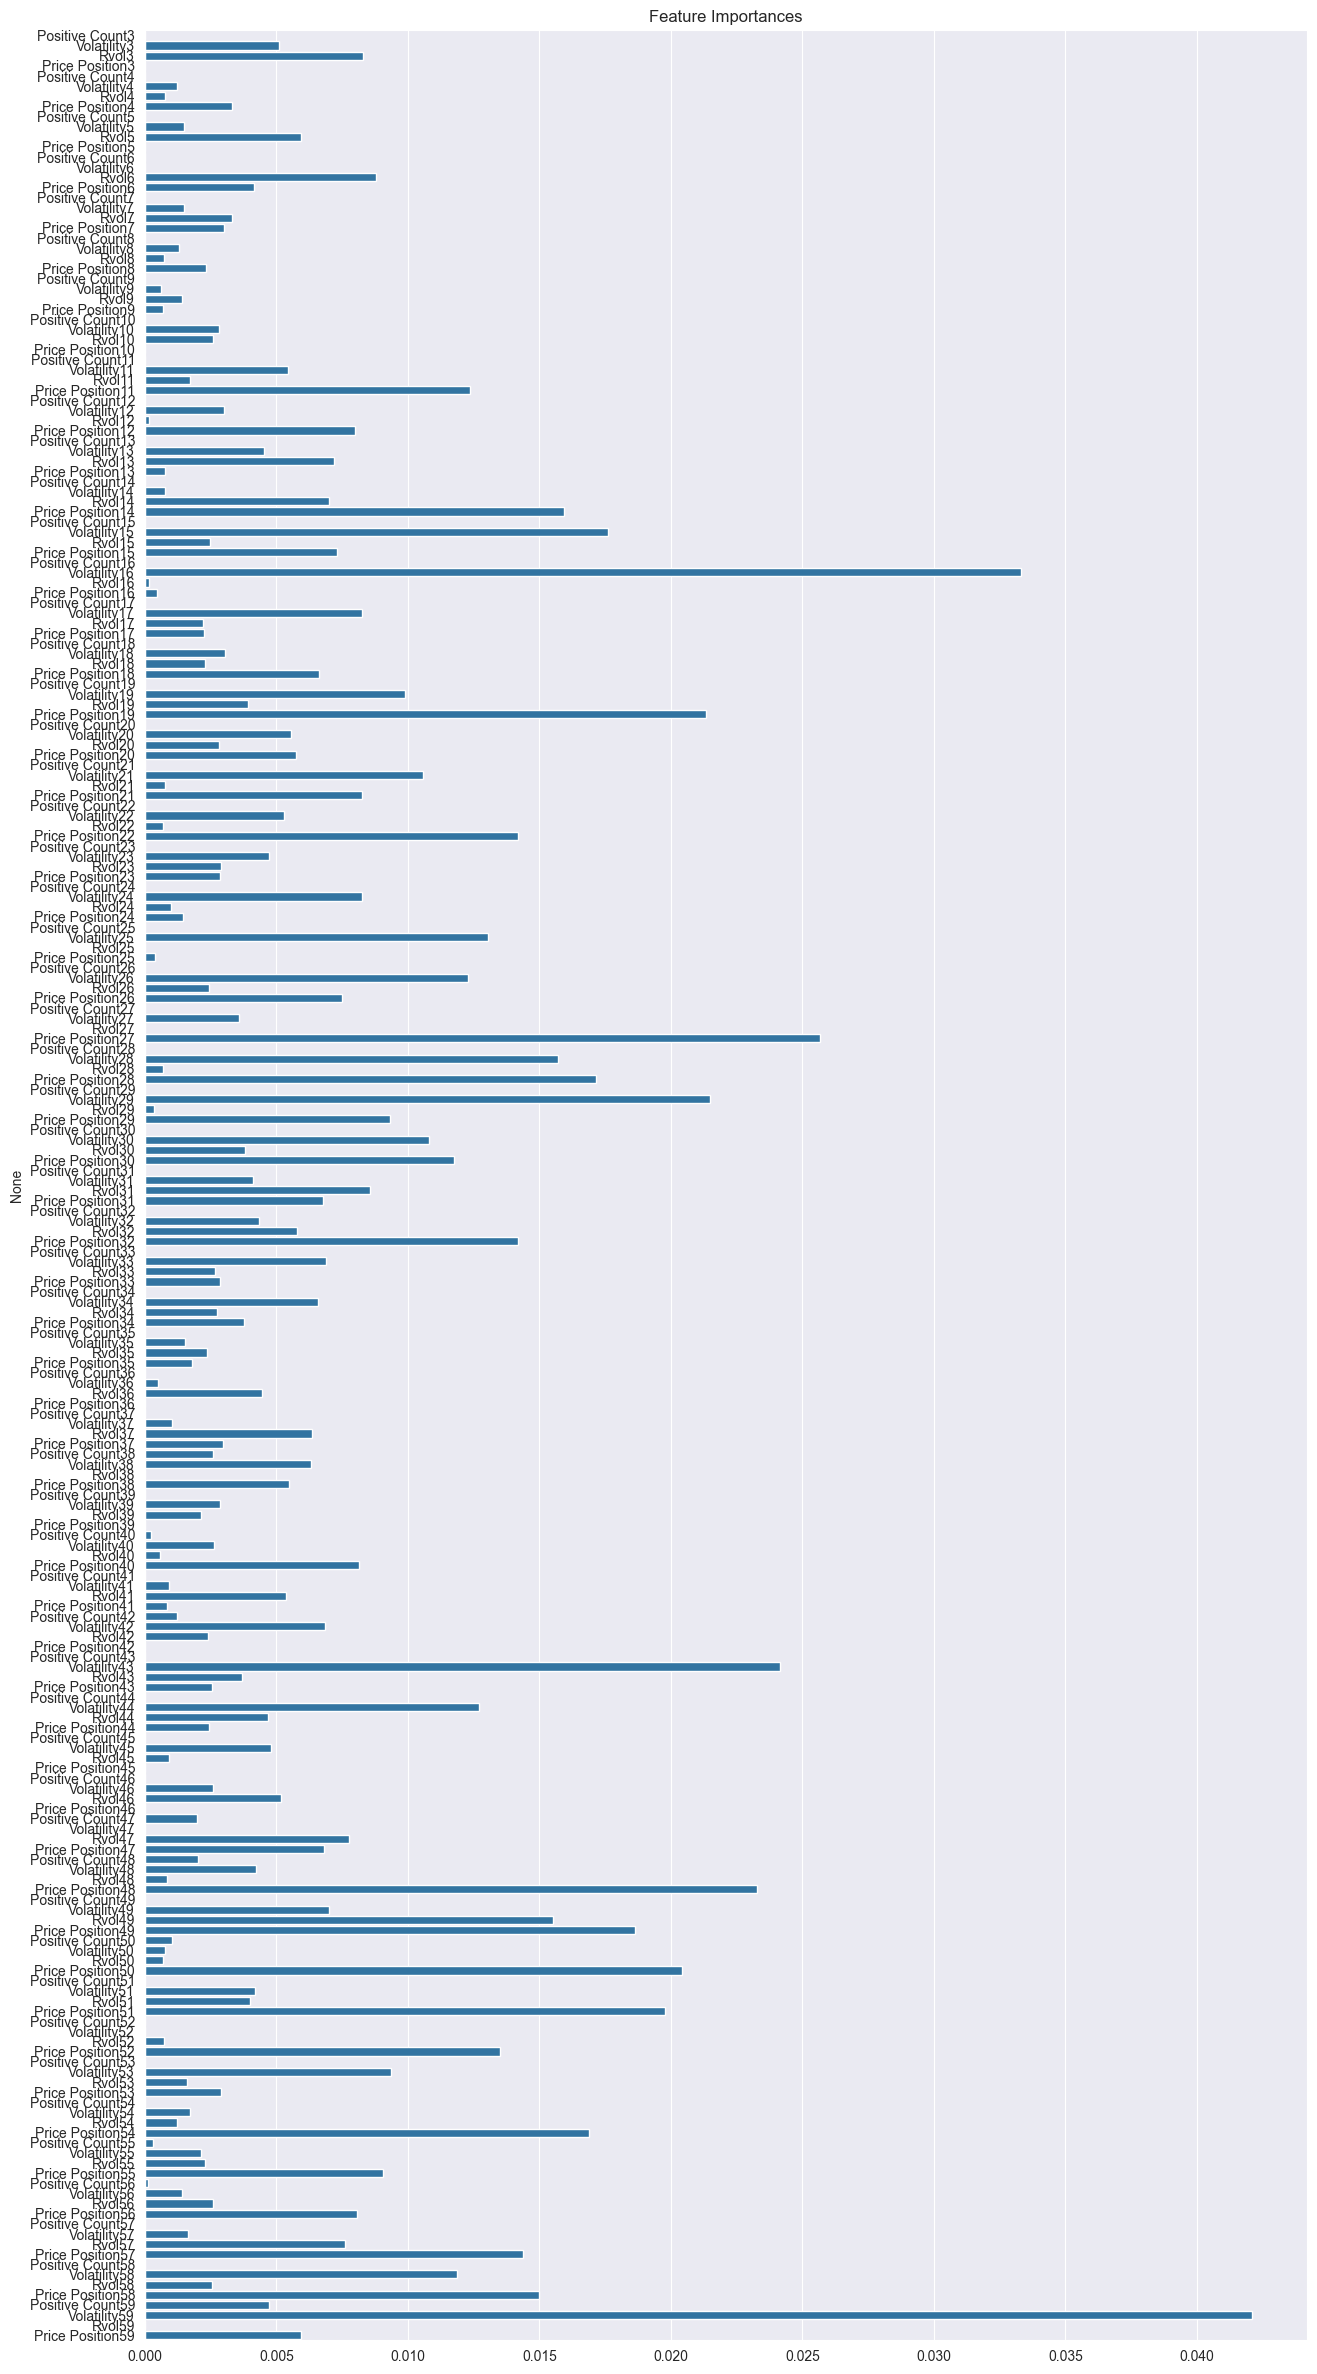

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

feature_importances = model.feature_importances_
features = stock_data.drop('MONEY', axis=1).columns

plt.figure(figsize=(15, 30))
sns.barplot(x=feature_importances, y=features)
plt.title("Feature Importances")
plt.yticks(fontsize=10)
plt.tight_layout
plt.show()